## Amir Cereal Data

In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
import timm
import ee
import geemap
import requests
from io import BytesIO

# Configuration
NEW_DATA_PATH = Path('CerealDataAmir/CerealData/cerealPoly_export.shp')
OUTPUT_DIR = Path('output/new_inference_data')
MODEL_PATH = Path('output/swin_cereal_classifier.pth')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
try:
    # Using the project ID from your previous work
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("Google Earth Engine initialized successfully!")
except Exception as e:
    print("Authenticating...")
    ee.Authenticate()
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("Authenticated and initialized.")

Google Earth Engine initialized successfully!


In [3]:
import geopandas as gpd
from shapely.geometry import Point, box
import math

# Function to generate grid points for a large geometry
def generate_tile_centers(geometry, patch_size_m=1280, stride_m=1280):
    """
    Splits a geometry into a grid of 1280m x 1280m tiles.
    Returns a list of center points (Lat/Lon) for each tile.
    """
    # 1. Create a temporary GeoSeries to handle projection
    gs = gpd.GeoSeries([geometry], crs="EPSG:4326")
    
    # 2. Reproject to a metric CRS (UTM) to measure in meters
    # Estimate the best UTM zone automatically
    crs_metric = gs.estimate_utm_crs()
    gs_metric = gs.to_crs(crs_metric)
    geom_metric = gs_metric.iloc[0]
    
    # 3. Get Bounding Box
    minx, miny, maxx, maxy = geom_metric.bounds
    
    # 4. Generate Grid Centers
    centers = []
    half_patch = patch_size_m / 2
    
    # Iterate x and y
    current_x = minx + half_patch
    while current_x < (maxx + half_patch): # Ensure we cover the edge
        current_y = miny + half_patch
        while current_y < (maxy + half_patch):
            # Create a candidate tile center
            center_point = Point(current_x, current_y)
            
            # Create the square tile footprint (for intersection check)
            # cap_style=3 creates a square buffer (bounding box)
            tile_poly = center_point.buffer(half_patch, cap_style=3)
            
            # Only keep this tile if it actually touches the user's polygon
            if tile_poly.intersects(geom_metric):
                centers.append(center_point)
            
            current_y += stride_m
        current_x += stride_m
        
    # 5. Convert centers back to Lat/Lon (WGS84)
    if not centers:
        return []
        
    centers_gs = gpd.GeoSeries(centers, crs=crs_metric).to_crs("EPSG:4326")
    return centers_gs.tolist()

# Function to download one specific patch
def download_single_tile(center_point, tile_id, output_dir):
    # Time range
    start_date = '2023-01-01'
    end_date = '2023-04-30'
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    
    # Define ROI: 1280m box around the center point
    # We buffer by 640m radius => 1280m width
    roi = ee.Geometry.Point([center_point.x, center_point.y]).buffer(640).bounds()
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    
    def mask_clouds(image):
        scl = image.select('SCL')
        mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
        return image.updateMask(mask)

    composite = s2.map(mask_clouds).select(bands).median()
    
    try:
        url = composite.getDownloadURL({
            'name': f'patch_{tile_id}',
            'bands': bands,
            'region': roi,
            'scale': 10,
            'format': 'NPY'
        })
        
        response = requests.get(url)
        data = np.load(BytesIO(response.content))
        
        if data.dtype.names:
            arr_list = [data[b].astype(np.float32) for b in bands]
            final_arr = np.stack(arr_list, axis=0)
        else:
            final_arr = data
            
        # Crop to exact 128x128
        _, h, w = final_arr.shape
        start_h = (h - 128) // 2
        start_w = (w - 128) // 2
        
        if start_h >= 0 and start_w >= 0:
            final_arr = final_arr[:, start_h:start_h+128, start_w:start_w+128]
            np.save(output_dir / f"S2_{tile_id}.npy", final_arr)
            return True
        return False
        
    except Exception as e:
        print(f"Error on {tile_id}: {e}")
        return False

# --- Main Execution ---
print(f"Loading shapefile: {NEW_DATA_PATH}")
gdf = gpd.read_file(NEW_DATA_PATH)
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

print(f"Found {len(gdf)} polygons. Generating grid tiles...")

total_tiles = 0
success_count = 0

# Iterate over every polygon in the shapefile
for poly_idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Polygons"):
    # Generate grid centers for this polygon
    centers = generate_tile_centers(row.geometry)
    
    # Download patch for each grid center
    for tile_idx, center in enumerate(centers):
        # Create a unique ID: PolyID_TileID
        unique_id = f"P{poly_idx}_T{tile_idx}"
        
        if download_single_tile(center, unique_id, OUTPUT_DIR):
            success_count += 1
        total_tiles += 1

print(f"\nProcessing Complete.")
print(f"Total tiles generated: {total_tiles}")
print(f"Successfully downloaded: {success_count}")

Loading shapefile: CerealDataAmir/CerealData/cerealPoly_export.shp
Found 1 polygons. Generating grid tiles...


Polygons:   0%|          | 0/1 [00:00<?, ?it/s]


Processing Complete.
Total tiles generated: 39
Successfully downloaded: 39


In [ ]:
# Re-create the model structure used in training
def create_swin_model(in_channels=10, num_classes=1, pretrained=False):
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=128
    )
    
    # Modify input layer for 10 channels
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    model.patch_embed.proj = new_proj
    return model

# Load Model
model = create_swin_model()
if MODEL_PATH.exists():
    # FIX: Added weights_only=False to resolve the UnpicklingError
    state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    
    # Handle case where checkpoint saves 'model_state_dict' key or just state_dict
    if 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("✓ Trained model loaded successfully.")
else:
    print(f"❌ Model not found at {MODEL_PATH}")

✓ Trained model loaded successfully.


In [5]:
class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        self.files = sorted(list(Path(data_dir).glob("S2_*.npy")))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        # Load and normalize
        img = np.load(file_path).astype(np.float32)
        img = img / 10000.0  # Normalize S2 data
        img = np.clip(img, 0, 1)
        
        # Get ID from filename "S2_123.npy" -> "123"
        patch_id = file_path.stem.split('_')[1]
        
        return torch.from_numpy(img), patch_id

# Create loader
inference_ds = InferenceDataset(OUTPUT_DIR)
inference_loader = DataLoader(inference_ds, batch_size=32, shuffle=False)
print(f"Ready to infer on {len(inference_ds)} samples.")

Ready to infer on 39 samples.


In [6]:
results = []

print("Running inference...")
with torch.no_grad():
    for images, ids in tqdm(inference_loader):
        images = images.to(device)
        
        # Predict
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)
        
        # Store results
        for patch_id, prob, pred in zip(ids, probs, preds):
            results.append({
                'id': patch_id,
                'class_pred': 'Cereal' if pred == 1 else 'Non-Cereal',
                'probability': f"{prob:.4f}",
                'raw_pred': pred
            })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Save to CSV
csv_path = 'output/new_data_predictions.csv'
df_results.to_csv(csv_path, index=False)

print(f"\n✓ Predictions saved to: {csv_path}")
print("\nSample results:")
print(df_results.head())

Running inference...


  0%|          | 0/2 [00:00<?, ?it/s]


✓ Predictions saved to: output/new_data_predictions.csv

Sample results:
   id  class_pred probability  raw_pred
0  P0      Cereal      0.9997         1
1  P0      Cereal      0.9997         1
2  P0  Non-Cereal      0.0003         0
3  P0  Non-Cereal      0.3295         0
4  P0      Cereal      0.9798         1


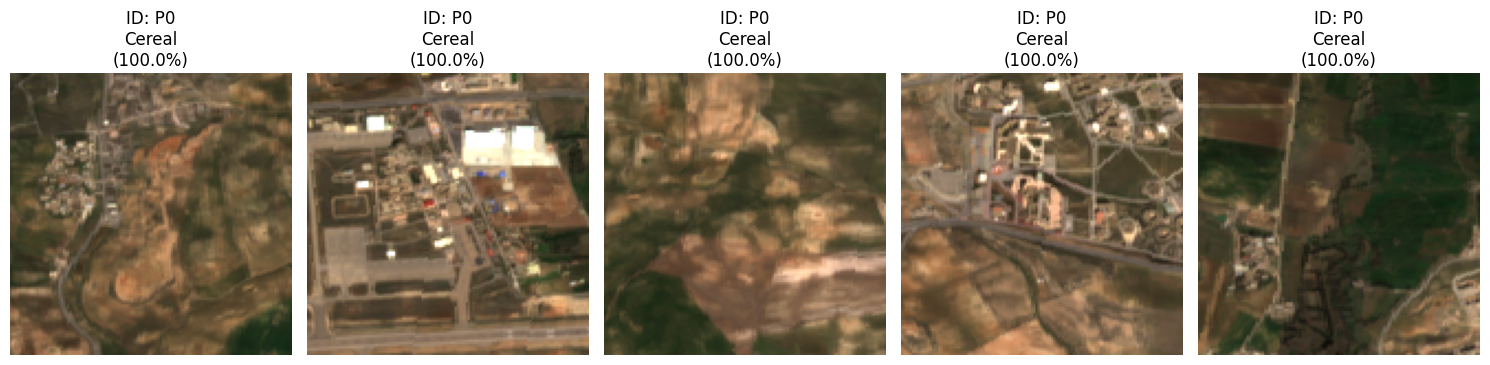

In [7]:
# Visualize a few random samples
if len(inference_ds) > 0:
    indices = np.random.choice(len(inference_ds), min(5, len(inference_ds)), replace=False)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 4))
    if len(indices) == 1: axes = [axes]
    
    for ax, idx in zip(axes, indices):
        img_tensor, patch_id = inference_ds[idx]
        
        # Get prediction
        row = df_results[df_results['id'] == patch_id].iloc[0]
        
        # Prepare image for display (RGB = Bands 2, 1, 0 which correspond to B4, B3, B2 in our 10-band stack)
        # S2_BANDS order: ['B2', 'B3', 'B4', ...] -> indices 0, 1, 2
        # We want RGB -> B4, B3, B2 -> indices 2, 1, 0
        rgb = img_tensor[[2, 1, 0], :, :].permute(1, 2, 0).numpy()
        rgb = np.clip(rgb * 2.5, 0, 1) # Brighten for display
        
        ax.imshow(rgb)
        ax.set_title(f"ID: {patch_id}\n{row['class_pred']}\n({float(row['probability']):.1%})")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()